# Confounding summary statistics for alternative demographic models

## The purpose of this notebook is simply to demonstrate how very similar sets of summary statistics can arise under  different demographic models of population continuity and admixture.

### 1) Design two demographic models; one involving strong private drift in one branch, and the other involving a population of constant size receiving a pulse of admixture from an unsampled source population.

### 2) Compute pairwise f2 stats and PCA results for each demographic model. 

### 3) Compute distances between these summary statistics calculated from data generated under each demographic model.

### 4) Iterate simulations and update, choosing simulation results that produce most similar sets of summary statistics. 

### 5) Plot the resulting summary statistics, showing that it is possible for similar patterns of genetic diversity to arise under different demographic models.

In [1]:
import msprime as msp
import random
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import math
from itertools import combinations, permutations
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import allel; print('scikit-allel', allel.__version__)
from allel.stats.misc import jackknife
import sys
from scipy.spatial import distance
from matplotlib import gridspec
import scipy.stats as st

scikit-allel 1.3.8


## Global togle to save / not-save figures

In [21]:
isSaveFigures = True

In [22]:
# Ignore some warnings when calculating summary stats with missing data, typically on Tajima's D and Fst (division by zero, etc) 
np.seterr(invalid='ignore',divide='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

# Functions to downsample perfect simulated data and introduce aDNA damages

In [23]:
### MAKE EMPTY GENOTYPE ARRAY ····························································
def empty_genotype_array(n_loci, n_samples, ploidy=2, allele=-1):
    """
    Creates a genotype array with all values as missing (-1) for a given number
    of samples, loci and ploidy

    :return: empty_ga
    """
    empty_ga = allel.GenotypeArray(np.full((n_loci, n_samples, ploidy), allele, dtype='i1'), dtype='i1')
    return empty_ga
  
def test_empty_genotype_array():
    test_ga = empty_genotype_array(3, 4, ploidy=2, allele=-1)
    assert type(test_ga) is allel.model.ndarray.GenotypeArray
    assert len(test_ga) == 3
    assert all(test_ga[0,0] == [-1,-1])
    assert all(test_ga[2,3] == [-1,-1])
    test_ga = empty_genotype_array(3, 4, ploidy=2, allele=0)
    assert all(test_ga[1,1] == [0,0])
### end MAKE EMPTY GENOTYPE ARRAY ····························································


### SNP CALLING FROM SIMULATED READS (WITH SEQUENCING ERROR)  ····························
def snp_calling(true_genotype, f_num_reads, error_rate=0.005, reads_th=8, score_th=5, ratio_th=10, damage=False, transversion=True):
    """
    snp_calling function takes perfect simulated data from one locus of one 
    diploid individual and adds missing data and error according to the number 
    of reads of the site, error rate of the sequencing technology and, for 
    ancient DNA not sequenced from damage repair (dr) libraries, creates 
    missing data for transition SNPs (since they cannot be distinguished from
    aDNA damage)

    :param true_genotype:
    :param f_num_reads:
    :param error_rate:
    :param reads_th:
    :param score_th:
    :param ratio_th:
    :param dr:
    :param transversion:
    :return:
    """
    genotype_call = [-1, -1]
    if damage is True and transversion is False:
        genotype_call = [-1, -1]
    elif f_num_reads >= reads_th:
        derived_count = sum(true_genotype)
        p_derived = derived_count / 2. * (1 - error_rate) + (1 - derived_count / 2.) * error_rate
        derived_reads = st.binom.rvs(f_num_reads, p_derived)
        ancestral_reads = f_num_reads - derived_reads
        if f_num_reads >= (score_th*2):
            if derived_reads == 0:
                genotype_call = [0, 0]
            elif ancestral_reads == 0:
                genotype_call = [1, 1]
            else:
                if (derived_reads >= score_th) & (ancestral_reads < score_th):
                    genotype_call = [1, 1]
                elif (derived_reads < score_th) & (ancestral_reads >= score_th):
                    genotype_call = [0, 0]
                elif (derived_reads >= score_th) & (ancestral_reads >= score_th):
                    ratio_of_scores = derived_reads / ancestral_reads
                    if (ratio_of_scores >= 1 / ratio_th) & (ratio_of_scores <= ratio_th):
                        if (derived_count == 1):
                            genotype_call = true_genotype
                        elif (st.binom.rvs(1, 0.5) == 1):
                            genotype_call = [0, 1]
                        else:
                            genotype_call = [1, 0]
                    elif derived_reads > ancestral_reads:
                        genotype_call = [1, 1]
                    else:
                        genotype_call = [0, 0]
    else:
        genotype_call = [-1, -1]
    #print(genotype_call)
    return genotype_call

def test_snp_calling():
    np.random.seed(1234)
    genotype_call = snp_calling( [0, 1], 100, error_rate=0.005, reads_th=1,
                  score_th=10, ratio_th=3, damage=False, transversion=True)
    assert genotype_call == [0,1]
    genotype_call = snp_calling( [0, 1], 1, error_rate=0.005, reads_th=10,
                  score_th=10, ratio_th=3, damage=False, transversion=True)
    assert genotype_call == [-1,-1]
### end SNP CALLING FROM SIMULATED READS (WITH SEQUENCING ERROR)  ····························

### SIMULATE SEQUENCING  ····························
def sequencing(ts, ssize, ttr, seq_error, damage, cov):
    if len(cov) != ssize:
        msg = "Number of coverage values (length=" + str(len(cov)) + \
              ") and number of samples (ssize=" + str(ssize) + \
              ") do not match"
        raise ValueError(msg)

    geno_data = empty_genotype_array(n_loci=ts.num_sites,
                                   n_samples=ssize,
                                   ploidy=2)
    positions = []
    locus = 0
    for variant in ts.variants():
        positions.append(round(variant.position))
        #print(variant.position)
        var_genotypes = variant.genotypes
        #print("variant genotypes = ", var_genotypes)
        num_reads = np.random.poisson(lam=cov, size=ssize)
        #print("num_reads = ", num_reads)
        transversion_snp = True
        if np.random.random() < ttr / (ttr + 1):
            transversion_snp = False
        for i in range(0, 2 * ssize, 2):
            if len(variant.alleles)==2:
                gt_call = snp_calling(true_genotype = var_genotypes[i:(i + 2)],
                                      f_num_reads = num_reads[int(i / 2)],
                                      damage = damage[int(i / 2)],
                                      transversion = transversion_snp)
            else:
                gt_call = [-1, -1] # this removes all SNP with more than two alleles
            geno_data[locus, int(i / 2)] = gt_call
        locus = locus + 1
        #print(locus)
    return geno_data, positions

# msprime simulations

Use msprime to generate data under two simple topologies. 

The idea here is to demonstrate that alternative demographies can give rise to qualitatively similar patterns of genetic variation and summary statistics. 

For each demographic model, recombination rate = 1.25 e-8, mutation rate = 1.45 e-8, generation time = 29 years. 7 samples are taken from 2 populations at 2 different time points (modern and ancient).

In [24]:
# fixed parameters
gen_time = 29
L = 2000000
mu = 1.45e-8 # equates to 0.5e-9/yr
r = 1.25e-8

# Demographic model 1

### Fixed splits, admixture dates and fractions:

In [25]:
t_AB_split = 55000/gen_time

ancient_sample_t = 50000/gen_time

# Population sizes
popA_N = 1000  
popB_N_start = 1000
popB_N_end = 100
popB_rate = -np.log(popB_N_end/popB_N_start) / t_AB_split # calculate growth rate required to decrease popB from start to end size
popAB_N = 1000

# build msprime demographies
demography1 = msp.Demography()
demography1.add_population(name="PA", initial_size=popA_N, default_sampling_time=0)
demography1.add_population(name="PB", initial_size=popB_N_start, growth_rate=popB_rate, default_sampling_time=0)
demography1.add_population(name="PAB", initial_size=popA_N, default_sampling_time=0)
demography1.add_population_split(time=t_AB_split, derived=['PA','PB'], ancestral='PAB') # add the fixed split to msprime's demography
demography1.sort_events()

# Demographic model 2

In [47]:
t_AB_split = 55000/gen_time
t_ABC_split = 200000/gen_time

ancient_sample_t = 50000/gen_time
adm_t, adm_frac = 35000/gen_time, 0.30 

# Population sizes
popA_N = 1000  
popB_N = 1000
popAB_N = 1000
popC_N = 5000  
popABC_N = 1000  

# build msprime demographies
demography2 = msp.Demography()
demography2.add_population(name="PA", initial_size=popA_N, default_sampling_time=0)
demography2.add_population(name="PB", initial_size=popA_N, default_sampling_time=0)
demography2.add_population(name="PC", initial_size=popA_N, default_sampling_time=0)
demography2.add_population(name="PAB", initial_size=popA_N, default_sampling_time=0)
demography2.add_population(name="PABC", initial_size=popA_N, default_sampling_time=0)
demography2.add_population_split(time=t_AB_split, derived=['PA','PB'], ancestral='PAB') # add the fixed split to msprime's demography
demography2.add_population_split(time=t_ABC_split, derived=['PAB','PC'], ancestral='PABC') # add the fixed split to msprime's demography
demography2.add_mass_migration(time=adm_t, source='PB', dest='PC', proportion=adm_frac)
demography2.sort_events()

### Set up the sampling regime

In [48]:
def set_up_samples(tS):
    samples = [msp.SampleSet(num_samples=3, population=0, time=tS[0], ploidy=2)] # 3 x moderns sampled from popA
    samples.extend([msp.SampleSet(num_samples=1, population=1, time=tS[1], ploidy=2)]) # ancient sampled from popB
    samples.extend([msp.SampleSet(num_samples=3, population=1, time=tS[0], ploidy=2)]) # 3 x moderns sampled from popB
    return samples

tS=[x/gen_time for x in [1,50000]]
Samples = set_up_samples(tS)

In [49]:
# First get haplotype array for all samples in each  results matrix
def pop_sample_ac(geno_arr):
    ac_1 = geno_arr[:,0:1].count_alleles()
    ac_2 = geno_arr[:,1:2].count_alleles()
    ac_3 = geno_arr[:,2:3].count_alleles()
    ac_4 = geno_arr[:,3:4].count_alleles()
    ac_5 = geno_arr[:,4:5].count_alleles()
    ac_6 = geno_arr[:,5:6].count_alleles()
    ac_7 = geno_arr[:,6:7].count_alleles()
    arrays = [ac_1,ac_2,ac_3,ac_4,ac_5,ac_6,ac_7]  # stack arrays
    return arrays

populations = np.array(['1', '2', '3', '4', '5', '6', '7'], dtype=object)
pop_colours = {
    '1': '#FF0000',
    '2': '#008000',
    '3': '#00FFFF',
    '4': '#90EE90',
    '5': '#FFA500',
    '6': '#8B0000',
    '7': '#1E90FF'
}

## Simulate and process data for a given demographic model object

In [50]:
# step 1 define simulation and processing functions
def simulate_and_process(demography, samples, sequence_length, recombination_rate, mutation_rate, num_runs):
    all_data = []
    total_samples = sum([ss.num_samples for ss in samples])  # Calculate total number of samples across all SampleSet objects
    for _ in range(num_runs):
        ts = msp.sim_ancestry(
            samples=samples,
            demography=demography,
            recombination_rate=recombination_rate,
            sequence_length=sequence_length,
            model=[msp.DiscreteTimeWrightFisher(duration=50), msp.StandardCoalescent()],
            random_seed=None
        )
        mut_ts = msp.sim_mutations(ts, rate=mutation_rate, random_seed=None)
        
        # Correct the coverage array to match the total number of samples
        damage = np.repeat([True, False], [0, total_samples])  # Assuming some pattern; adjust as necessary
        cov = np.repeat([50.0], total_samples)  # Assuming uniform coverage for simplicity; adjust as necessary
        
        geno_data, positions = sequencing(ts=mut_ts, ssize=total_samples, ttr=2.1, seq_error=0.005, damage=damage, cov=cov)
        all_data.append((geno_data, positions))
    return all_data


## Calculate the summary statistics for generated datasets

In [51]:
# Step 2 define statistics and calculation function
def calculate_f2_and_pca(geno_data):
    # Assuming geno_data is already a GenotypeArray object
    ac = geno_data.count_alleles()
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gn = geno_data.compress(flt, axis=0).to_n_alt()
    
    # Calculate f2 statistics
    sample_names = ["1", "2", "3", "4", "5", "6", "7"]
    ac_samples = pop_sample_ac(geno_data)
    ac_dict = dict(zip(sample_names, ac_samples))
    f2_dict = {}
    for combo in combinations(sample_names, 2):
        f2_arr = allel.patterson_f2(ac_dict[combo[0]], ac_dict[combo[1]])
        f2_dict[combo[0] + "," + combo[1]] = np.nanmean(f2_arr)
    
    # Perform PCA
    coords, model = allel.randomized_pca(gn, n_components=2, scaler='patterson')
    
    return f2_dict, coords, model


## Compare and update summary statistics across simulations

In [52]:
# Step 3: define comparison function
def compare_statistics(f2_dict_1, f2_dict_2, coords1, coords2):   
    # Extract values corresponding to the same keys in both dictionaries
    values1 = np.array([f2_dict_1[k] for k in sorted(f2_dict_1)])
    values2 = np.array([f2_dict_2[k] for k in sorted(f2_dict_2)])
    
    # Calculate Pearson correlation coefficient for f2 statistics
    correlation_coefficient = np.corrcoef(values1, values2)[0, 1]
    
    # Comparing PCA coordinates by Euclidean distance
    pca_diff = np.linalg.norm(coords1 - coords2)
    
    return correlation_coefficient, pca_diff

def update_best_match(f2_corr, pca_norm, current_best_scores, f2_weight=0.5, pca_weight=0.5):
    f2_dist = 1 - f2_corr # Calculate "distance" from correlation 
    
    pca_dist = pca_norm  

    # Weighted sum of normalized scores
    current_score = f2_weight * f2_dist + pca_weight * pca_dist

    # Compare and update best matches if current score is better
    if current_score < current_best_scores:
        return current_score, True
    return current_best_scores, False

## Iterate simulations and compare results

In [57]:
# Step 4: Main script to control simulation and comparison
num_runs = 1000
best_f2_1 = None
best_f2_2 = None
best_coords1 = None
best_coords2 = None

best_score = float('inf')
for i in range(num_runs):
    data1 = simulate_and_process(demography1, Samples, L, r, mu, 1)
    data2 = simulate_and_process(demography2, Samples, L, r, mu, 1)
    
    f2_1, coords1, model1 = calculate_f2_and_pca(data1[0][0])
    f2_2, coords2, model2 = calculate_f2_and_pca(data2[0][0])
    
    f2_corr, pca_norm = compare_statistics(f2_1, f2_2, coords1[:, :2], coords2[:, :2])
    best_score, is_updated = update_best_match(f2_corr, pca_norm, best_score)
    
    # Update best matches
    if is_updated:
        print(f"New best match found with f2 correlation {f2_corr} and PCA norm {pca_norm}")
        best_f2_1 = f2_1
        best_f2_2 = f2_2
        best_coords1 = coords1
        best_coords2 = coords2

# Final output of best matches
print("Done")


New best match found with f2 correlation 0.8304975168043702 and PCA norm 165.49160766601562
New best match found with f2 correlation 0.7047955926418699 and PCA norm 145.88243103027344
New best match found with f2 correlation 0.7932961346198021 and PCA norm 134.80711364746094
New best match found with f2 correlation 0.8191140639290251 and PCA norm 132.2309112548828
New best match found with f2 correlation 0.8752877028307154 and PCA norm 131.2119598388672
New best match found with f2 correlation 0.9116606091161247 and PCA norm 45.3648567199707
New best match found with f2 correlation 0.955922685105577 and PCA norm 25.275896072387695
New best match found with f2 correlation 0.9111644177944873 and PCA norm 23.040388107299805
New best match found with f2 correlation 0.8748478343023838 and PCA norm 20.21312141418457
New best match found with f2 correlation 0.9206233106491675 and PCA norm 17.39897346496582
New best match found with f2 correlation 0.8975441894654657 and PCA norm 13.99596023559

## Visualize results for each demographic model side-by-side

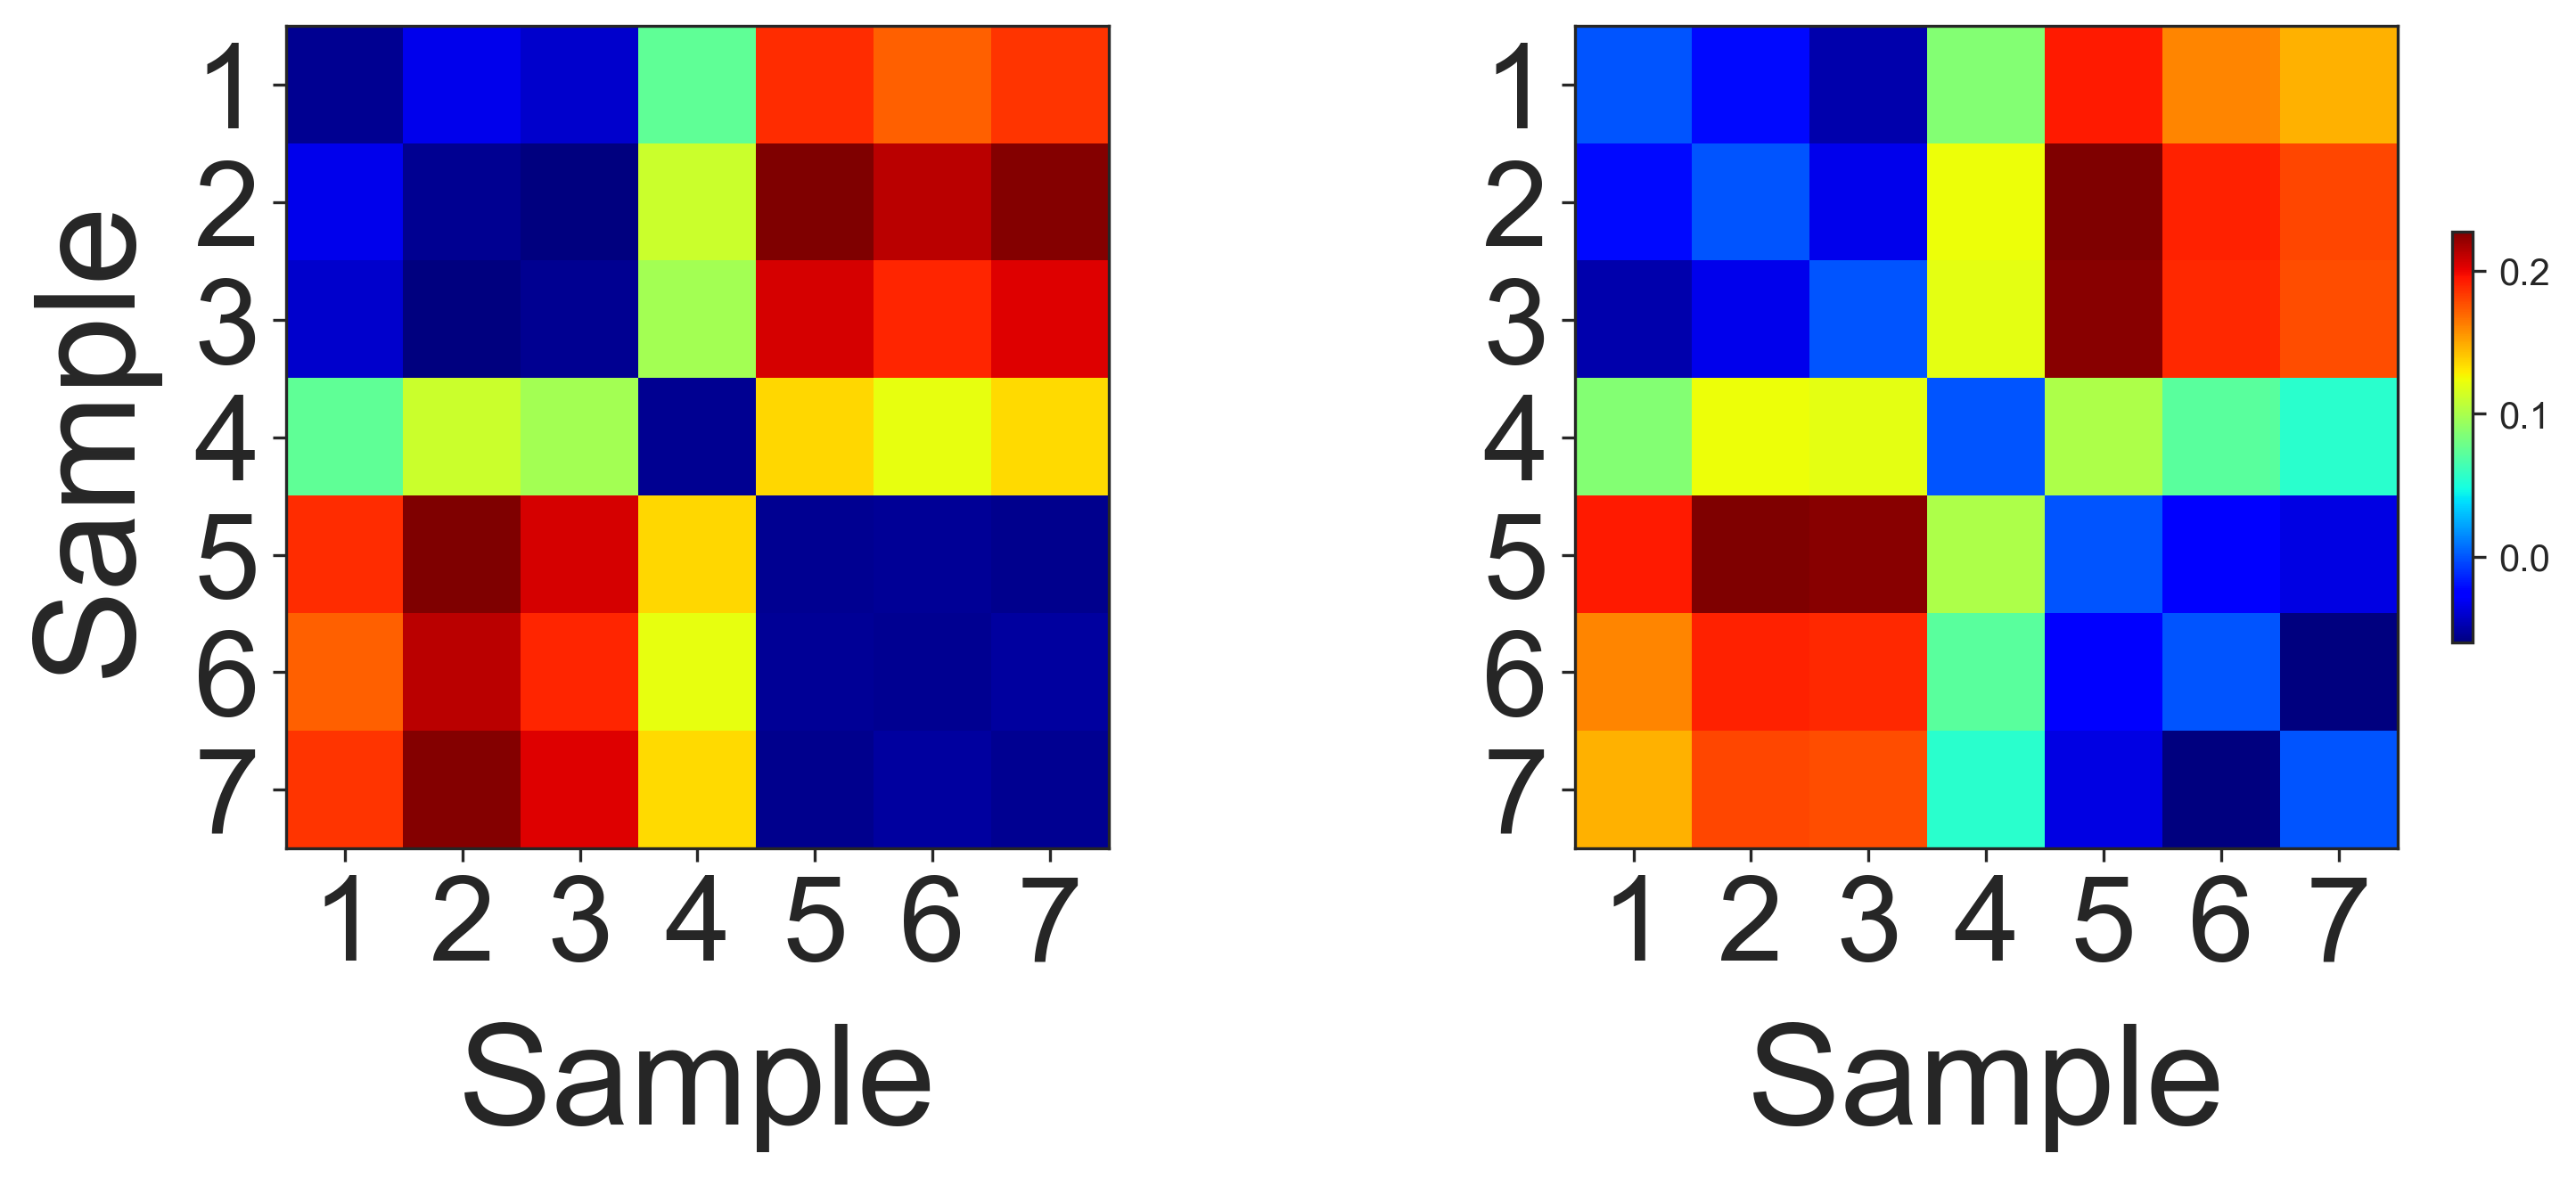

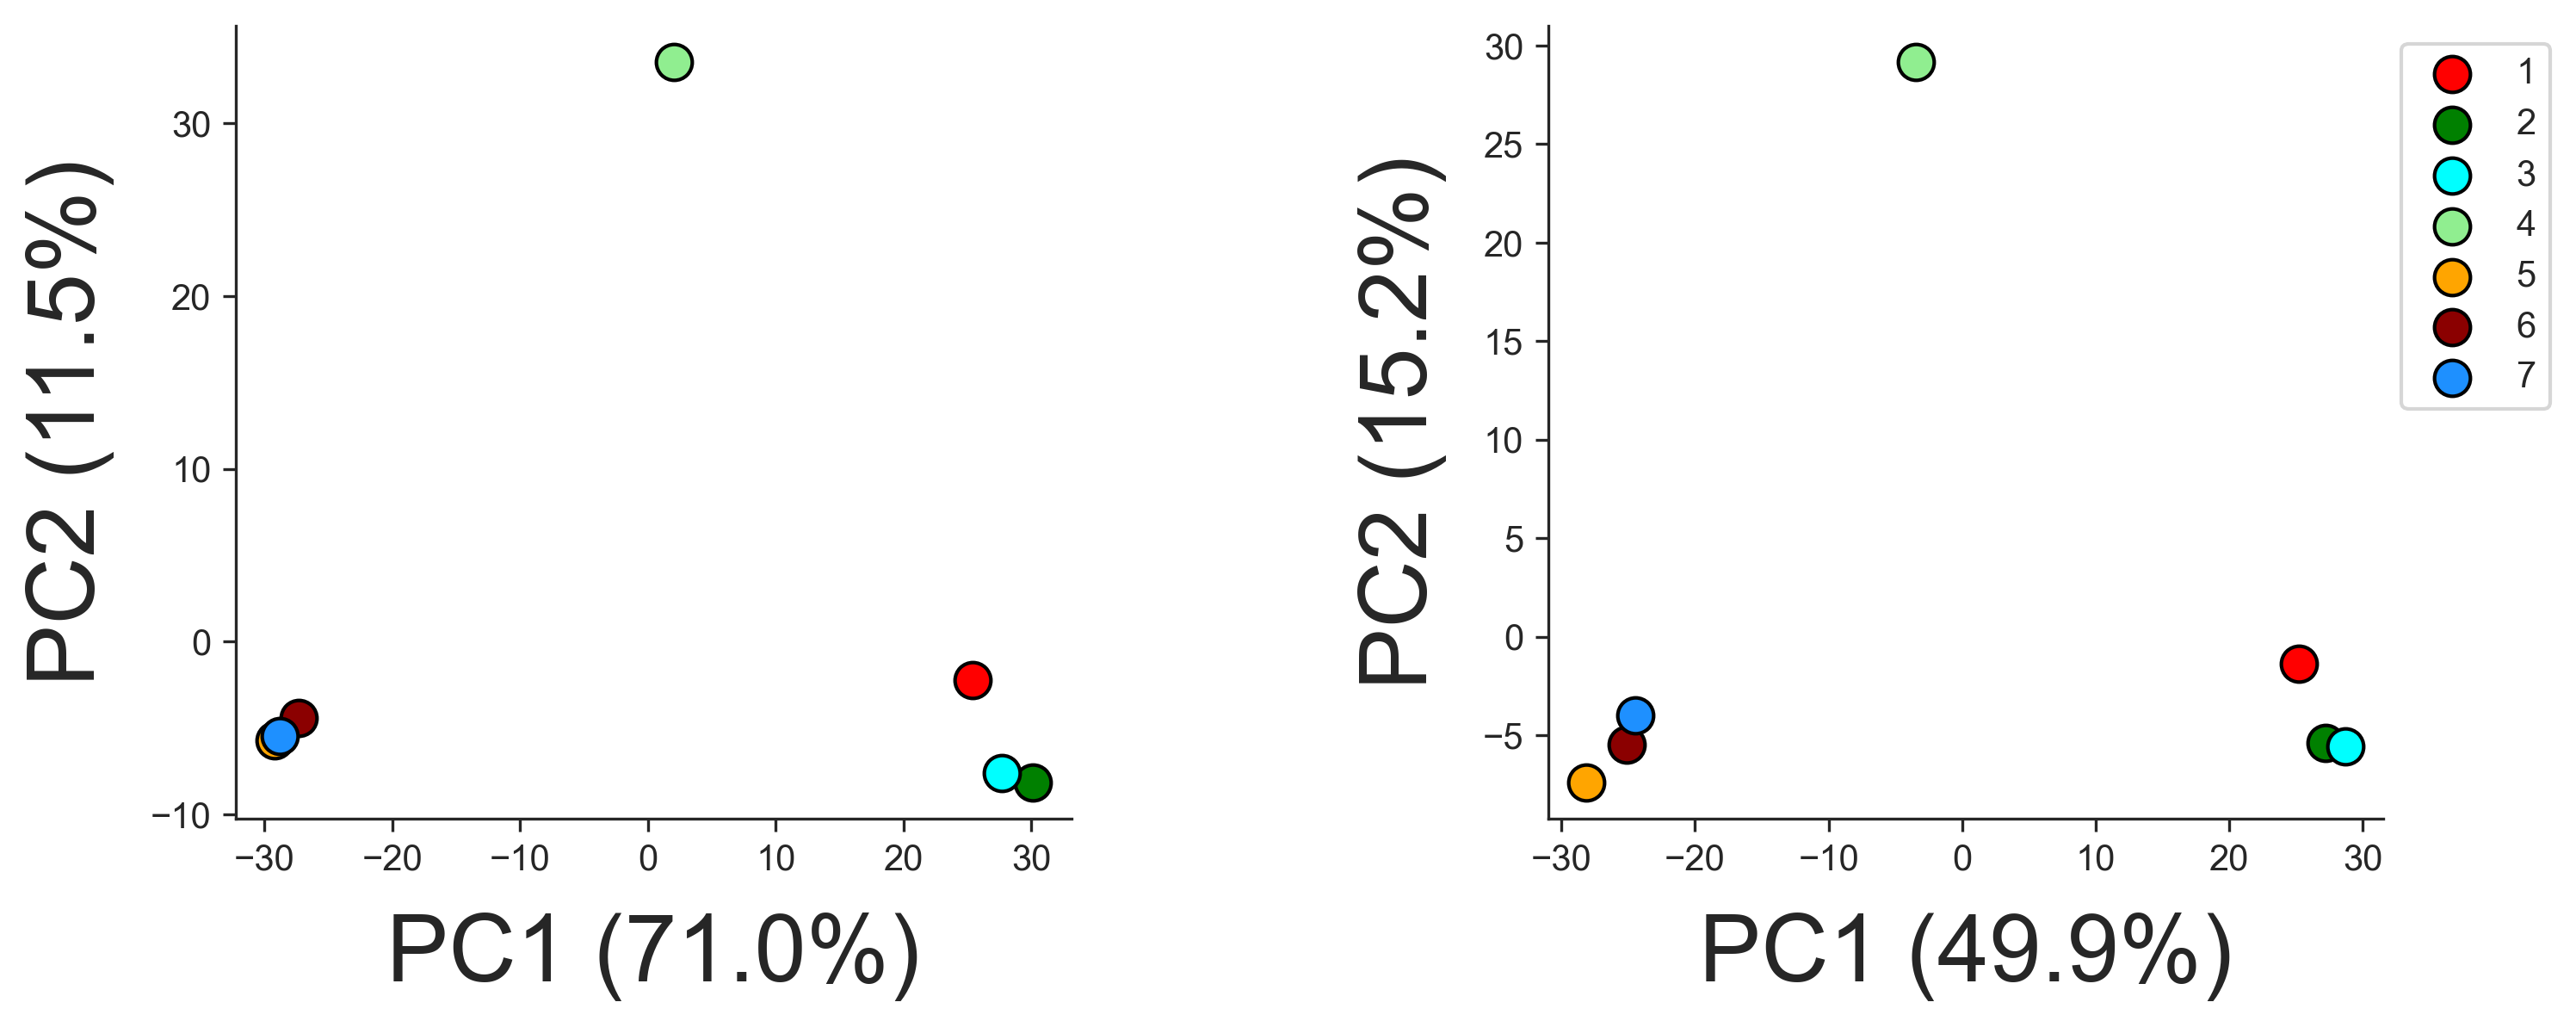

In [71]:
def plot_f2_matrices_side_by_side(f2s_1, f2s_2, save_fig=False):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1.25]}, dpi=300)

    # Adjusting the font sizes for the axes labels and title
    font_size_labels = 38  # Font size for X and Y labels
    font_size_ticks = 32   # Font size for tick labels
    label_padding = 10     # Padding between the labels and the axis

    # Plot f2 statistics for the first demographic model without a colorbar
    im1 = allel.plot_pairwise_distance(np.array(list(f2s_1.values())), labels=[1, 2, 3, 4, 5, 6, 7], colorbar=False, ax=axs[0])
    axs[0].set_xlabel('Sample', fontsize=font_size_labels, labelpad=label_padding)
    axs[0].set_ylabel('Sample', fontsize=font_size_labels, labelpad=label_padding)
    axs[0].tick_params(axis='x', labelrotation=0, labelsize=font_size_ticks)  # Rotate x-axis labels vertically
    axs[0].tick_params(axis='y', labelsize=font_size_ticks)

    # Plot f2 statistics for the second demographic model without a colorbar
    im2 = allel.plot_pairwise_distance(np.array(list(f2s_2.values())), labels=[1, 2, 3, 4, 5, 6, 7], colorbar=True, ax=axs[1])
    axs[1].set_xlabel('Sample', fontsize=font_size_labels, labelpad=label_padding)
    axs[1].tick_params(axis='x', labelrotation=0, labelsize=font_size_ticks)  # Rotate x-axis labels vertically
    axs[1].tick_params(axis='y', labelsize=font_size_ticks)

    fig.tight_layout(pad=8)  # Adjust layout to make room for plot labels
    if save_fig:
        plt.savefig('Figures/f2_Comparison.png')
    plt.show()


def plot_pca_side_by_side(coords1, coords2, model1, model2, populations, pop_colours, save_fig=False):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

    # Settings for visual enhancements
    font_size_labels = 26  # Font size for axis labels
    font_size_subtitle = 20  # Font size for subtitles
    point_size = 100  # Size of the scatter plot points
    edge_color = 'black'  # Color of the point borders
    label_padding = 10     # Padding between the labels and the axis

    # Extract variance explained percentages for axis titles
    var1 = model1.explained_variance_ratio_ * 100
    var2 = model2.explained_variance_ratio_ * 100

    # Plot PCA for the first demographic model
    for pop in populations:
        flt = (populations == pop)
        axs[0].scatter(coords1[flt, 0], coords1[flt, 1], label=pop, color=pop_colours[pop],
                      s=point_size, edgecolor=edge_color)
    axs[0].set_xlabel(f'PC1 ({var1[0]:.1f}%)', fontsize=font_size_labels, labelpad=label_padding)
    axs[0].set_ylabel(f'PC2 ({var1[1]:.1f}%)', fontsize=font_size_labels, labelpad=label_padding)

    # Plot PCA for the second demographic model
    for pop in populations:
        flt = (populations == pop)
        axs[1].scatter(coords2[flt, 0], coords2[flt, 1], label=pop, color=pop_colours[pop],
                      s=point_size, edgecolor=edge_color)
    axs[1].set_xlabel(f'PC1 ({var2[0]:.1f}%)', fontsize=font_size_labels, labelpad=label_padding)
    axs[1].set_ylabel(f'PC2 ({var2[1]:.1f}%)', fontsize=font_size_labels, labelpad=label_padding)
    axs[1].legend(bbox_to_anchor=(1, 1), loc='upper left')

    # Simplifying plot appearance
    for ax in axs:
        ax.spines['top'].set_visible(False)  # Remove top line
        ax.spines['right'].set_visible(False)  # Remove right line    
    
    fig.tight_layout(pad=8)  # Adjust layout to make room for plot labels
    if save_fig:
        plt.savefig('Figures/PCA_Comparison.png')
    plt.show()

# Assuming you have the required data from your analysis
plot_f2_matrices_side_by_side(best_f2_1, best_f2_2, isSaveFigures)
plot_pca_side_by_side(best_coords1, best_coords2, model1, model2, populations, pop_colours, isSaveFigures)
